In [1]:
import matplotlib
matplotlib.use("svg")
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import glob

# PDS Homework 6 Logistics

- **Due date:** Saturday December 3rd
- **Notebooks**: Map Reduce, Deep Learning, Probabilistic Modeling (PyMC)
- **Grading:** 
    - All notebooks are weighted equally (DL notebook has a contest, so you can score up to 38/35 on that one).
    - Required: 388: 1/3 notebooks, 688: 2/3 notebooks.
    - Extra credit: One extra notebook, for half the points. Extra credit will be applied even if you've scored full in all the previous homeworks.
    - Autograder will be out in a couple of days.

# Map Reduce

This notebook does not require new libraries. We'll just be  using the `MapReduceJob` class contained in the notebook. 

I will go over the word count example (given already in the notebook):
- **Given**: A corpus of documents containing words.
- **To find**: The counts of every word which is not a stop word in the entire corpus.

This is how we will do it:
- **Map phase**: Process each line of each file, emitting < word, count=1> for each word encountered.
- **Reduce phase**: Receives all counts for the same word and sums them to emit < word, total count> pair.

I've pasted the code for the framework and the word count example's mapper and reducer in a python file which I will now import.

In [2]:
import map_reduce
from map_reduce import MapReduceJob # framework
from map_reduce import file_to_words # mapper
from map_reduce import count_words # reducer

In [3]:
# create an instance of MapReduceJob with the mapper and reducer of word count task, by invoking the __init__ function.
# num_worker=k creates k threads on which the mappers/reducers will be run. Default value: None
wordcount_job = MapReduceJob(file_to_words, count_words, num_workers=2, worker_context=None)
# list of input files
input_files = glob.glob('programming/data/wordcount/*.rst')
# run the job, by invoking the __call__ function. chunksize=k distributes k files per mapper.
word_counts = wordcount_job(input_files, chunksize=1)
# view output
print word_counts

PoolWorker-1 reading programming/data/wordcount/file1.rst
PoolWorker-2 reading programming/data/wordcount/file2.rst
PoolWorker-2 outputting [('2', 1), ('3', 1), ('4', 1)]
PoolWorker-1 outputting [('1', 1), ('2', 1), ('3', 1)]
PoolWorker-1 reading programming/data/wordcount/file4.rst
PoolWorker-2 reading programming/data/wordcount/file3.rst
PoolWorker-2 outputting [('3', 1), ('4', 1), ('5', 1)]
PoolWorker-1 outputting [('6', 1), ('0', 1), ('1', 1)]
[('1', 2), ('0', 1), ('3', 3), ('2', 2), ('5', 1), ('4', 2), ('6', 1)]


# Deep Learning

In this notebook, you'll be using two new libraries -- PILLOWS (image processing) and Keras (deep learning).

## PILLOWS
This is the Python Imaging Library. The most important class in this module is `Image`. Let's import it.

In [4]:
from PIL import Image

### Open an image
You can create an instance of this class in a bunch of ways, e.g., by opening an image file.

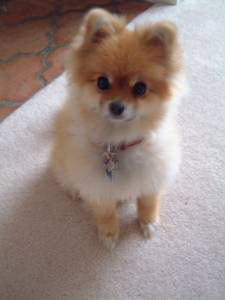

In [33]:
im = Image.open('pic.jpg') # opens pic.jpg and creates an instance of the Image class
im

### View image and its properties
Now, we can view the image itself or some of its attributes, e.g., format or color mode.

JPEG (225, 300) RGB


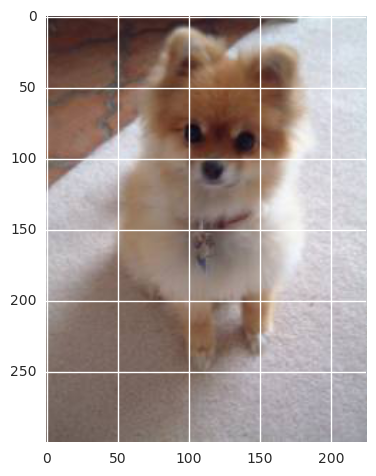

In [34]:
print im.format, im.size, im.mode # view some image attributes
im.show() # displays the loaded image in a new window
plt.imshow(im) # displays image inline

Pay attention to the coordinate system: x values increase rightwards, y values increase downwards.

### Image processing basics
The image object can also be processed in multiple ways, e.g., converted into another format, cropped, resized.

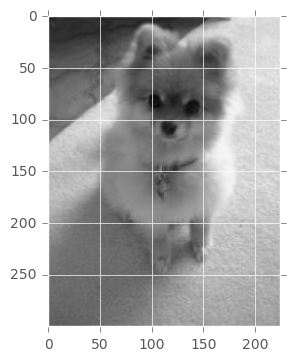

In [7]:
im_bw = im.convert('LA') # convert to greyscale. You can convert to RGB by passing 'RGB' instead of 'LA'
plt.imshow(im_bw)

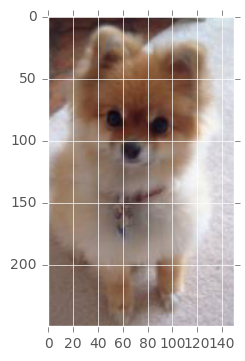

In [8]:
im_cropped = im.crop((50, 0, 200, 250)) # crop image given x_start, y_start, x_end, y_end
plt.imshow(im_cropped)

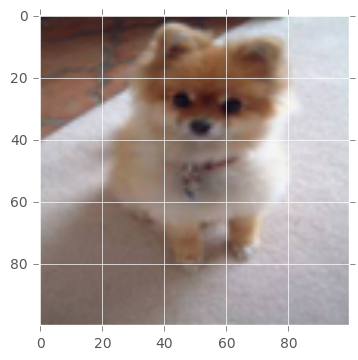

In [9]:
im_resized = im.resize((100, 100), Image.ANTIALIAS)
plt.imshow(im_resized)

The `resize` function takes two inputs: (1) the size of the final image (2) the filter which specifies the sampling mechanism. 

The default value for filter argument is NEAREST (nearest neighbour). You should use Image.ANTIALIAS, the highly recommended filter from documentation, unless speed is much more important than quality.

## KERAS
Keras is a Python library for developing and evaluating deep learning models. We'll need the following imports.

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Our example here is based on http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/. We will work with randomly generated data containing 8 real-valued inputs and a binary output (0 or 1).

In [11]:
np.random.seed(0) # always a good idea to pass a known seed, for reproducibility of experiments
N,d = 100,8
X = np.random.random((N,d)) # N*d array of inputs
Y = np.random.randint(0, 2, size=(N,1), dtype=int) # N-dimensional binary array of outputs

### Create a model

A model in Keras is a sequence of layers. We can create a `Sequential` model to which we can add layers one by one. At the very least, our model should have two layers:
- the first layer, which should take the correct input dimension. (here, 8)
- the last layer, which has the same number of neurons as the output dimension. (here, 1)

How to decide the number or type of layers? A very hard question and the answer is usually, by trial and error. The general rule of thumb is to go as big as the training data size allows, so that the network is large enough to capture the structure of the problem, if at all.

It's not uncommon to reuse pre-trained networks which are known to perform well in some application. In fact, this is what you will do in the homework. In constrast, now we will see how we can create and train a model from scratch. We'll use a full connected network structure with three layers.

In [12]:
# create a sequential model
model = Sequential()
# dense class => fully connected network structure
# 1st layer: 12 neurons, 8 input variables, weights initialized from uniform dist., relu activation function.
model.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
# 2nd layer: 8 neurons, weights initialized from uniform dist., relu activation function.
model.add(Dense(8, init='uniform', activation='relu'))
# last layer: 1 neuron = output dimension, weights initialized from uniform dist., sigmoid activation function.
model.add(Dense(1, init='uniform', activation='sigmoid'))

RELU activation layer is found to work well in practice and is used for hidden/input layers. The output layer uses the sigmoid function and outputs a value between 0 and 1, which is a useful for a binary classification problem.

In the homework, you'll be adding convolutional, maxpooling, zeropadding layers which are known to work well with images, but the basic procedure remains the same.

### Compiling the model
Compiling the model is the process of specifying additional properties required when training the network.

In [13]:
# compile the model
# specify loss function to use to evaluate the weights, optimizer used to search through the weight space and
# the metrics we wish to monitor 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training and evaluating the model

In [14]:
# train: fit to training data
model.fit(X, Y, nb_epoch=150, batch_size=10)
# evaluate: how well can the model predict output on training data?
scores = model.evaluate(X, Y)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
100/100 [==============================] - 0s - loss: 0.6932 - acc: 0.4800     
Epoch 2/150
100/100 [==============================] - 0s - loss: 0.6932 - acc: 0.4900     
Epoch 3/150
100/100 [==============================] - 0s - loss: 0.6932 - acc: 0.4300     
Epoch 4/150
100/100 [==============================] - 0s - loss: 0.6932 - acc: 0.5100     
Epoch 5/150
100/100 [==============================] - 0s - loss: 0.6931 - acc: 0.5100     
Epoch 6/150
100/100 [==============================] - 0s - loss: 0.6931 - acc: 0.5100     
Epoch 7/150
100/100 [==============================] - 0s - loss: 0.6932 - acc: 0.5100     
Epoch 8/150
100/100 [==============================] - 0s - loss: 0.6931 - acc: 0.5100     
Epoch 9/150
100/100 [==============================] - 0s - loss: 0.6931 - acc: 0.5100     
Epoch 10/150
100/100 [==============================] - 0s - loss: 0.6931 - acc: 0.5100     
Epoch 11/150
100/100 [==============================] - 0s - loss: 0.6931 - acc

### Making predictions
Here's how we use our model on test data.

In [15]:
# get an output in [0,1]
predictions = model.predict(X)
print predictions[:10]
# round it to 0 or 1 to get the predicted class
y_hat = [round(x) for x in predictions]
print y_hat[:10]

[[ 0.34757456]
 [ 0.58254522]
 [ 0.30225685]
 [ 0.56506121]
 [ 0.50469911]
 [ 0.14573093]
 [ 0.21900083]
 [ 0.6862824 ]
 [ 0.5186708 ]
 [ 0.75852698]]
[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0]


# Energy Disaggregation

### Creating the model
The basic element that you will need to be familiar with is how to create random variables using PyMC.  For the most part, this is fairly simple.

In [16]:
import pymc as pm

In [17]:
# uniformly distributed variable: name, lower bound of interval, upper bound of interval
t = pm.Uniform("t", 0, 1)
# normally distributed variable: name, mean, inverse variance
mu1 = pm.Normal("mu1", 0, 0.1)
mu2 = pm.Normal("mu2", 0, 0.1)
# variable following gamma distribution
tau = pm.Gamma("tau", 2.0, 1.0)

We can also group a set of variables into what are called `containers`.

In [18]:
N = 100
x = pm.Container([pm.Uniform("x_{}".format(i), 0, 1) for i in range(N)])
y = pm.Container([pm.Normal("y_{}".format(i), (x[i]<t)*mu1 + (x[i]>=t)*mu2, tau) for i in range(N)])

Once, we have defined the variables individually, we can create a model out of them as follows.

In [19]:
model = pm.Model([t,mu1,mu2,tau,x,y])
model

### Sampling from the model

In order to actually draw samples from the above model, you can use the call:

In [20]:
model.draw_from_prior()

After making this call, the random variables .value property contains a sample of the random variable, as drawn from the prior distribution.

In [21]:
print t.value

0.742003599815


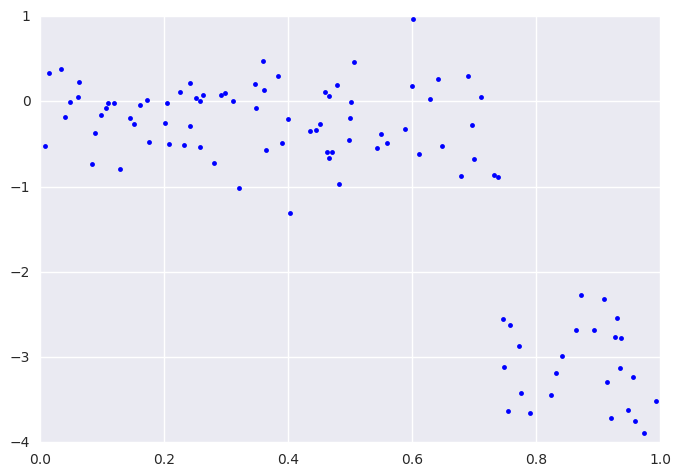

In [22]:
import seaborn
plt.plot(x.value, y.value, 'b.')

You can compute the loglikihood of the model (computed based upon the current value of each random variable), using the function

In [23]:
model.logp

-64.69217673881965

### Observed variables and MCMC
When creating a random variable, you can specify the `observed` and `value` parameters in the initalizer in order to indicate that a random variable is observed.  For example, in the above, we could instead do:

In [24]:
x0 = np.random.rand(N)
y0 = (x0 < 0.5)*1.0 + (x0 >=0.5)*-1.0 + 0.5*np.random.randn(N)

In [25]:
x = pm.Container([pm.Uniform("x_{}".format(i), 0, 1, observed=True, value=x0[i]) for i in range(N)])
y = pm.Container([pm.Normal("y_{}".format(i), (x[i]<t)*mu1 + (x[i]>=t)*mu2, tau, observed=True, value=y0[i]) 
                  for i in range(N)])

model = pm.Model([t,mu1,mu2,tau,x,y])

Now we create an MCMC object and draw samples from it.

In [26]:
mcmc = pm.MCMC(model)
mcmc.sample(1000, burn=100)

 [-----------------100%-----------------] 1000 of 1000 complete in 29.9 sec

You can access the samples (with the initial `burn` samples thrown away), using the `.trace()` method.

(array([  53.,   91.,   88.,   74.,  182.,  220.,   81.,   64.,   33.,   14.]),
 array([ 2.15197461,  2.48804066,  2.82410671,  3.16017276,  3.49623881,
         3.83230486,  4.16837091,  4.50443696,  4.84050301,  5.17656907,
         5.51263512]),
 <a list of 10 Patch objects>)

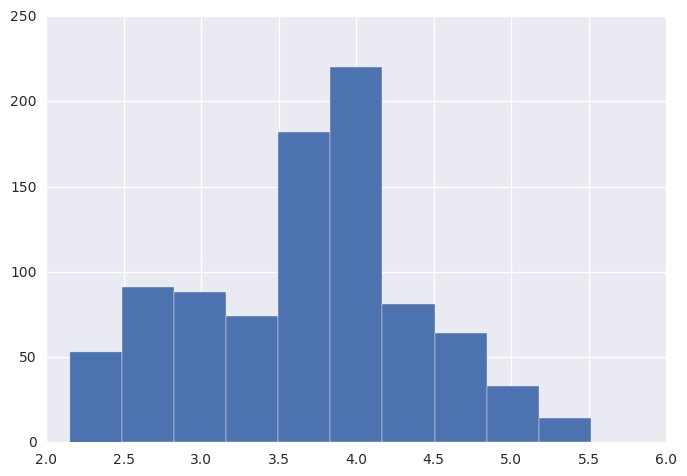

In [27]:
plt.hist(tau.trace()[:])

### Categorical variables
One last element that you'll need for the assignment, is the ability to index into arrays using categorical variables, and the `pm.Index()` call.  Consider the following setup, where we create a categorial random variable `z`, and then create 4 means, and we want to the categorical variable to index into the means.

In [28]:
z = pm.Categorical("z", p=np.ones(4)/4.)
mu = pm.Container([pm.Normal("mu_{}".format(i)) for i in range(4)])

We would like to do something like:

    mu[z]

but this is not a valid expression in PyMC.  Instead, we use the command `pm.Index()`, which selects the relevant item of `mu` based upon the value of `z`

In [29]:
pm.Index("mu_z", mu, z)

<pymc.CommonDeterministics.Index '[<pymc.distributions.Normal 'mu_0' at 0x12817fcd0>, <pymc.distributions.Normal 'mu_1' at 0x12817fad0>, <pymc.distributions.Normal 'mu_2' at 0x128253790>, <pymc.distributions.Normal 'mu_3' at 0x12507cf10>][z]' at 0x12500c4d0>

### Example: Gaussian Mixture Model
Let's see how we can use this within a more complex example.  Let's consider a version of a "Bayesian Gaussian Mixture Model", which is essentially very similar to our Gaussian Mixture Model that we learned with EM, but the parameters are all themselves random variables.  Our model is given by:

\begin{equation}
\begin{split}
\mu_j & \sim \mathcal{N}(0, \sigma^2)\ \ \   \forall j=1,\ldots,k \\
\tau_j & \sim \mathrm{Gamma}(\alpha, \beta)\ \ \  \forall j=1,\ldots,k \\
\phi & \sim \mathrm{Dirichlet}(\theta) \\
z^{(i)} & \sim \mathrm{Categorical}(\phi)\ \ \   \forall i=1,\ldots,m \\
x^{(i)} &\sim \mathcal{N}(\mu_{z^{(i)}}, 1/\tau_{z^{(i)}})\ \ \  \forall i=1,\ldots,m \\
\end{split}
\end{equation}

with hyperparameters $\theta, \sigma^2, \alpha, \beta$.  We write this in PyMC as the following:

In [30]:
# hyper parameters
k = 3
m = 100
theta = np.ones(k)
sigma2 = 1.0
alpha = 5.0
beta = 0.1
# random variables
# mu and tau
mu = pm.Container([pm.Normal("mu_{}".format(i), 0, 1/sigma2) for i in range(k)])
tau = pm.Container([pm.Gamma("tau_{}".format(i), alpha, beta) for i in range(k)])
# phi and z
phi = pm.Dirichlet("phi", theta)
z = pm.Container([pm.Categorical("z_{}".format(i), phi) for i in range(m)])
# finally, x
x = pm.Container([pm.Normal("x_{}".format(i), pm.Index(None, mu, z[i]), pm.Index(None, tau, z[i])) for i in range(m)])
# model from random variables
model = pm.Model([phi, mu, tau, z, x])

In [31]:
# sample from the model
model.draw_from_prior()
print mu.value
print tau.value
print phi.value

[array(-1.245751887560529), array(-0.8739530417985735), array(0.542274978420372)]
[array(69.62678877158248), array(33.677004786929196), array(46.49974062480805)]
[ 0.03604658  0.68176651]


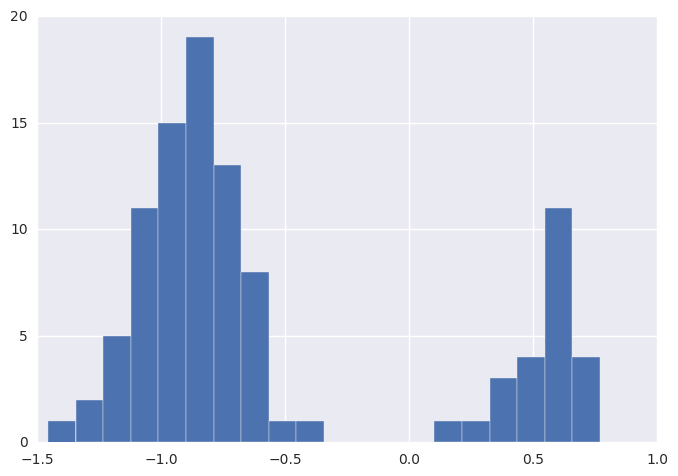

In [32]:
plt.hist(x.value, bins=20);

### Link to documentation

Official PyMC docs: http://pymc-devs.github.io/pymc/

Another good PyMC resource: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb

Note that both these tutorials describe a way to build models using decorator syntax `@pm.determistic` or `@pm.stochastic`, but you don't need to do this for the homework, you can just use the methods that appear in this notebook.